### Notes:
- train only on the elements in the material?

### To-do:
- still need to handle stoichiometry case which contains "("
- grab insulator and conductor data from MP.org
- documentation: doc strings & code comments
- improve model
    - visualize: https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db
- model tests
- make into package:
    - https://python-packaging-tutorial.readthedocs.io/en/latest/setup_py.html

In [1]:
import numpy as np
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "../src/")
from material import Material
from bandgappredictions import BandGapPredictions

In [2]:
Cd22S45 = Material(formula="Cd22S45",density=2.34)
Si3Ge4 = Material(formula="Si3Ge4",density=1.23,volume=57)
SiGe = Material(formula="SiGe",density=3.824,volume=43.741,formation_energy=0.024,
                crystal_system="cubic",spacegroup="F43m",E_above_hull=0.024,Nsites=2) #taken from mp-1219182

materials_list = [Cd22S45,Si3Ge4,SiGe]
csv_path = "../data/training/materialsproject_output/"
json_path = "../data/training/materialsproject_json/"
band_gap_predictions = BandGapPredictions(csv_path,json_path,materials_list)
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects

ridge regression alpha_choice = 0.20506122448979594
ridge regression alpha_choice = 0.20506122448979594
ridge regression alpha_choice = 0.20506122448979594


In [3]:
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    print(f""" 
    {material}
    -----------
    model score: {band_gap_prediction_object.model_score}
    band gap: {band_gap_prediction_object.predicted_band_gap} eV""")

 
    Cd22S45
    -----------
    model score: 0.39967102175668084
    band gap: 1.517149096738117 eV
 
    Si3Ge4
    -----------
    model score: 0.3341591416974088
    band gap: 1.0983191132942962 eV
 
    SiGe
    -----------
    model score: 0.5580244017452876
    band gap: 0.8863940744464238 eV


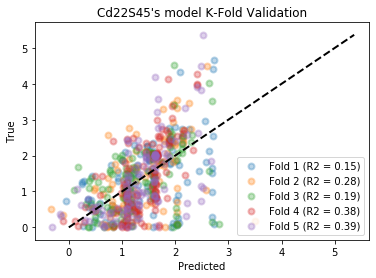

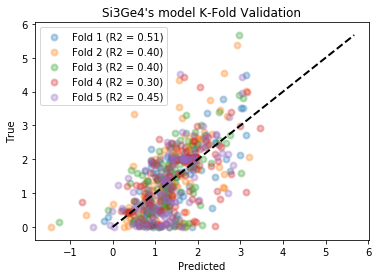

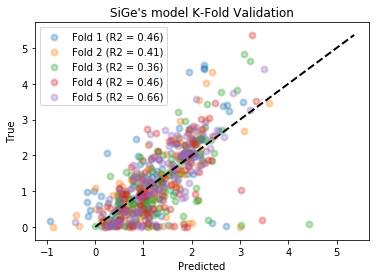

In [5]:
# K fold validation
# https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    scores = list()
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1

    X_train = band_gap_prediction_object.X_train
    y_train = band_gap_prediction_object.y_train
    model = band_gap_prediction_object.model
    
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train],
                        y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, 
                    label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
                linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{material}'s model K-Fold Validation")
    plt.legend()
    plt.show()